# Importing useful libraries

In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import ConfusionMatrixDisplay

# Analyzing the data we are working with

In [2]:
# Base variables
superpopulation_code_colors = ['#D9EDF8', '#FFADAD', '#E4F1EE', '#FFD6A5', '#DEDAF4', '#FDFFB6']

superpopulation_code_dict = {
    'EUR': 0,
    'EAS': 1,
    'AMR': 2,
    'SAS': 3,
    'AFR': 4,
    'EUR,AFR': 5
}

In [23]:
real_filename = "REAL.hapt"
real_labels = "REAL.tsv"
ag_filename = "WGAN.hapt"

In [4]:
# Importing real data
real_df = pd.read_csv('./data/' + real_filename, delimiter = ' ').reset_index(drop=True)
labels_df = pd.read_csv('./data/' + real_labels, header = 0, sep = '\t')
real_df.iloc[:, 1] = real_df.iloc[:, 1].astype(str).str[:-2]
real_df = real_df.merge(labels_df[['Sample name','Superpopulation code', 'Population code']], left_on=real_df.iloc[:, 1], right_on='Sample name', how='inner')
real_df['Superpopulation code'].replace(superpopulation_code_dict, inplace=True)
real_df = real_df.drop(columns='Sample name')
real_df.drop(real_df[real_df['Superpopulation code'] == 5].index, inplace = True)
real_df

,Type,Sample,0,1,2,3,4,5,6,7,...,9992,9993,9994,9995,9996,9997,9998,9999,Superpopulation code,Population code
0,Real,HG00096,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,GBR
1,Real,HG00096,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,GBR
2,Real,HG00097,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,GBR
3,Real,HG00097,1,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,GBR
4,Real,HG00099,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,GBR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5003,Real,NA21142,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,3,GIH
5004,Real,NA21143,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,3,GIH
5005,Real,NA21143,1,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,3,GIH
5006,Real,NA21144,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,3,GIH


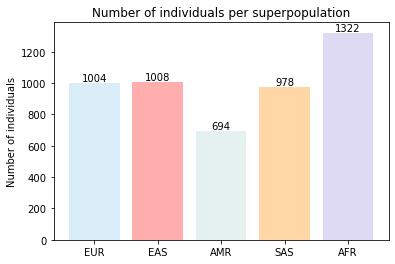

In [5]:
# Looking at the proportions for each superpopulation
fig, ax = plt.subplots()

individual_per_pop = []
pop_names = ["EUR", "EAS", "AMR", "SAS", "AFR"]
for i in range(5):
    individual_per_pop.append(real_df[real_df['Superpopulation code'] == i].shape[0])

bars = ax.bar(pop_names, height=individual_per_pop, color=superpopulation_code_colors)
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 10, yval, horizontalalignment='center')
ax.set_ylabel('Number of individuals')
ax.set_title('Number of individuals per superpopulation')

plt.show()

# Knn

In [6]:
# Base variables
NUMBER_OF_NEIGHBORS = 6
MODEL = KNeighborsClassifier
SNP = 9999

In [7]:
X = real_df.iloc[:, 3:SNP + 3]
y = np.ravel(real_df.iloc[:, SNP + 3:SNP + 4])
y = y.astype(int)

## How many neighbors?

In [8]:
_scores = []
_neighbors = [i+1 for i in range(36)]

for i in _neighbors:
    NUMBER_OF_NEIGHBORS = i
    knn_model = MODEL(n_neighbors = NUMBER_OF_NEIGHBORS)
    knn_model.fit(X, y)
    _scores.append(knn_model.score(X, y))
    if i % 4 == 0: print(str(i) + '/' + str(len(_neighbors)))

4/36
8/36
12/36
16/36
20/36
24/36
28/36
32/36
36/36


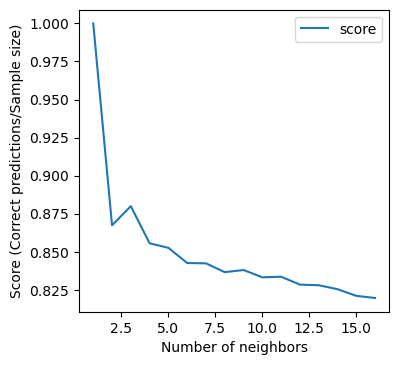

In [9]:
_x = [i+1 for i in range(16)]
plt.figure(figsize=(4, 4), dpi=100)
plt.plot(_x, _scores[0: 16], '-', label="score")
#plt.plot(_x, scores10k[0: 16], 'g-', label="10k")
plt.xlabel("Number of neighbors")
plt.ylabel("Score (Correct predictions/Sample size)")
plt.legend()
plt.show()

In [10]:
knn_model = MODEL(n_neighbors = NUMBER_OF_NEIGHBORS)
knn_model.fit(X, y)

KNeighborsClassifier(n_neighbors=36)

In [11]:
predictions = knn_model.predict(X)

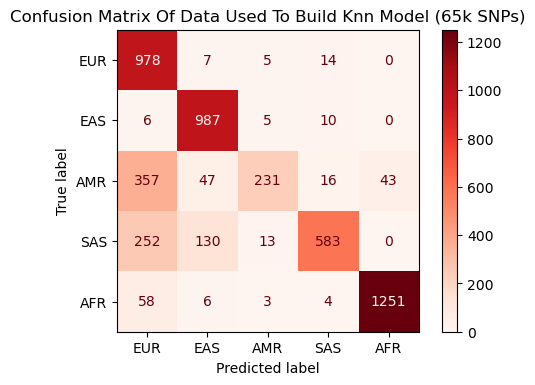

In [12]:
disp = ConfusionMatrixDisplay.from_estimator(
    knn_model,
    X,
    y,
    cmap=plt.cm.Reds,
    display_labels=["EUR", "EAS", "AMR", "SAS", "AFR"],
    normalize=None,
)

disp.ax_.set_title("Confusion Matrix Of Data Used To Build Knn Model (65k SNPs)")
fig = disp.ax_.get_figure() 
#fig.set_figwidth(20)
fig.set_dpi(100)

## Investigating subpopulations

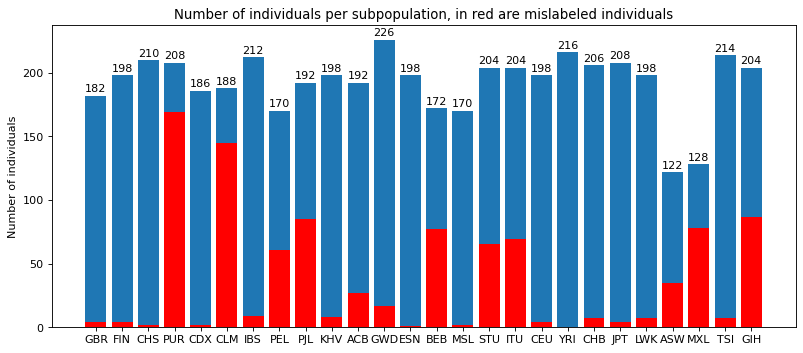

In [13]:
sub_population_dict = {}
for i in range(len(predictions)):
    if i < 1220 or i > 1221:
        if not real_df['Population code'][i] in sub_population_dict: sub_population_dict[real_df['Population code'][i]] = {'total': 0, 'errors': 0}
        sub_population_dict[real_df['Population code'][i]]['total'] += 1
        if predictions[i] != y[i]: sub_population_dict[real_df['Population code'][i]]['errors'] += 1 

fig, ax = plt.subplots(figsize=(12,5))
fig.set_dpi(80)
heights_total = []
errors_total = []
for key in sub_population_dict.keys():
    heights_total.append(sub_population_dict[key]['total'])
    errors_total.append(sub_population_dict[key]['errors'])
bars = ax.bar(sub_population_dict.keys(), height=heights_total)
ax.bar(sub_population_dict.keys(), height=errors_total, color='r')
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 3, yval, horizontalalignment='center')
ax.set_ylabel('Number of individuals')
ax.set_title('Number of individuals per subpopulation, in red are mislabeled individuals')
plt.show()

## Labeling AGs

In [29]:
ag_df = pd.read_csv('./data/' + ag_filename, delimiter = ' ')
ag_df.head()

,Type,Sample,0,1,2,3,4,5,6,7,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,AG,AG0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,AG,AG1,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,AG,AG2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AG,AG3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AG,AG4,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


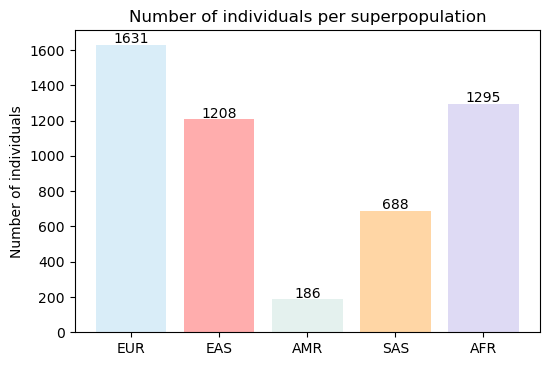

In [30]:
ag_df["Superpopulation code"] = knn_model.predict(ag_df.iloc[:, 3:SNP + 3])

superpopulation_code_dict = {
    0 : 'EUR',
    1 : 'EAS',
    2 : 'AMR',
    3 : 'SAS',
    4 : 'AFR'
}

superpopulation_code_colors = ['#D9EDF8', '#FFADAD', '#E4F1EE', '#FFD6A5', '#DEDAF4']

fig, ax = plt.subplots()
fig.set_dpi(100)

individual_per_pop = []
pop_names = ["EUR", "EAS", "AMR", "SAS", "AFR"]
for i in range(5):
    individual_per_pop.append(ag_df[ag_df['Superpopulation code'] == i].shape[0])

bars = ax.bar(pop_names, height=individual_per_pop, color=superpopulation_code_colors)
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 10, yval, horizontalalignment='center')
ax.set_ylabel('Number of individuals')
ax.set_title('Number of individuals per superpopulation')

plt.show()

ag_df["Superpopulation code"].replace(superpopulation_code_dict, inplace=True)

In [31]:
ag_tsv = ag_df[["Sample", "Superpopulation code"]]
ag_tsv.to_csv("./generated/WGAN.tsv", sep=",", na_rep='', index=False)
ag_tsv.head()

,Sample,Superpopulation code
0,AG0,EAS
1,AG1,EAS
2,AG2,EAS
3,AG3,EAS
4,AG4,AFR


## Reducing dimensions

In [14]:
from sklearn.manifold import TSNE

In [15]:
X_numpy = X.to_numpy()
tsme = TSNE(n_components=2).fit_transform(X_numpy)

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [16]:
knn_model_tsne = MODEL(n_neighbors = NUMBER_OF_NEIGHBORS)
knn_model_tsne.fit(X_numpy, y)

KNeighborsClassifier(n_neighbors=36)

In [17]:
train_preds = knn_model.predict(X)
mse = mean_squared_error(y, train_preds)
rmse = sqrt(mse)
print("The mean squared error for our model is: ", rmse)

The mean squared error for our model is:  1.063880533637202


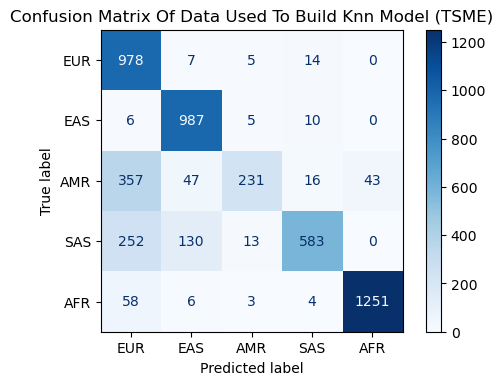

In [21]:
disp = ConfusionMatrixDisplay.from_estimator(
    knn_model,
    X,
    y,
    cmap=plt.cm.Blues,
    display_labels=["EUR", "EAS", "AMR", "SAS", "AFR"],
    normalize=None
)

disp.ax_.set_title("Confusion Matrix Of Data Used To Build Knn Model (TSME)")
fig = disp.ax_.get_figure()
fig.set_dpi(100)
plt.show()